# Structure analysis
ref: [link](https://userguide.mdanalysis.org/stable/examples/analysis/structure/README.html)

In [1]:
import warnings 

import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np

from MDAnalysis.tests.datafiles import PSF, DCD, DCD2, GRO
from MDAnalysis.analysis import gnm

%matplotlib inline
warnings.filterwarnings('ignore')

## Elastic network analysis
Here we use a Gaussian network model to characterise conformational states of a trajectory.

In [2]:
# load files
u1 = mda.Universe(PSF, DCD)
u2 = mda.Universe(PSF, DCD2)

### Using a Gaussian network model
Using a Gaussian network model to represent a molecule as an elastic network, we can characterise the concerted motions of a protein, and the dominance of these motions, over a trajectory. The analysis is applied to the atoms in the `selection`. If two atoms are within the `cutoff` distance (default: 7 ångström), they are considered to be bound by a spring. This analysis is reasonably robust to the choice of cutoff (between 5-9 Å), but the singular value decomposition may not converge with a lower cutoff.

In [3]:
# using a Gaussian network model
nma1 = gnm.GNMAnalysis(u1,
                      select='name CA',
                      cutoff=7.0)
nma1.run()
# The output is saved in nma1.results: 
# the time in picoseconds, the first eigenvalue, and 
# the first eigenvector, associated with each frame.

In [4]:
list(nma1.results.keys())

['eigenvalues', 'eigenvectors', 'times']

In [5]:
(len(nma1.results['eigenvalues']), len(nma1.results['eigenvectors']),
    len(nma1.results['times']))

(98, 98, 98)

In [6]:
nma2 = gnm.GNMAnalysis(u2,
                      select='name CA',
                      cutoff=7.0)
nma2.run()

Unlike normal mode analysis, Gaussian network model analysis uses only a single eigenvalue to represent the rotation and translation of each frame. The motion with the lowest positive eigenvalue represents the dominant motion of a structure. The frequency of this motion is the square root of the eigenvalue.

Plotting the probability distribution of the frequency for the first eigenvector can highlight variation in the probability distribution, which can indicate trajectories in different states.

Below, we plot the distribution of eigenvalues. The dominant conformation state is represented by the peak at 0.06.

Text(0, 0.5, 'Frequency')

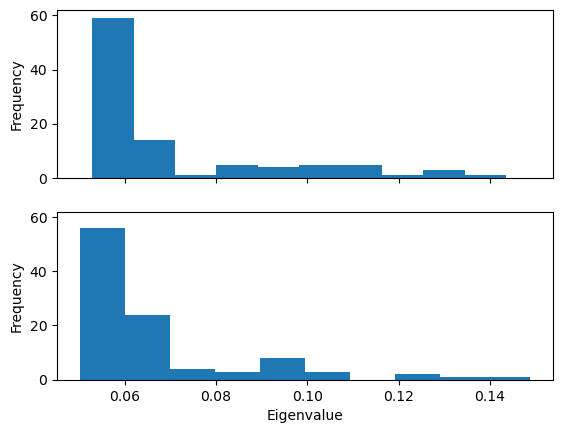

In [7]:
histfig, histax = plt.subplots(nrows=2, sharex=True, sharey=True)
histax[0].hist(nma1.results['eigenvalues'])
histax[1].hist(nma2.results['eigenvalues'])

histax[1].set_xlabel('Eigenvalue')
histax[0].set_ylabel('Frequency')
histax[1].set_ylabel('Frequency')

# When we plot how the eigenvalue varies with time, 
# we can see that the simulation transitions into 
# the dominant conformation and stays there 
# in both trajectories.

When we plot how the eigenvalue varies with time, we can see that the simulation transitions into the dominant conformation and stays there in both trajectories.

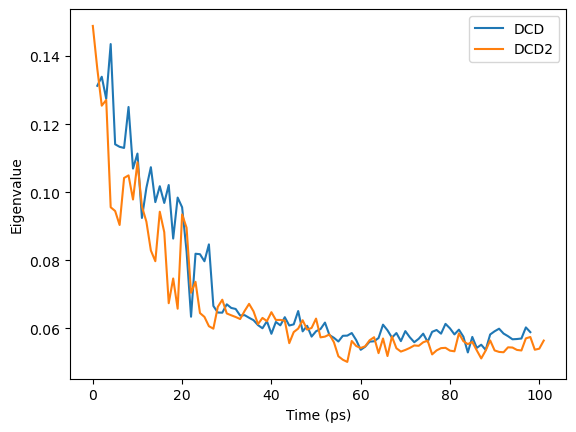

In [8]:
linefig, lineax = plt.subplots()
plt.plot(nma1.results['times'], nma1.results['eigenvalues'], label='DCD')
plt.plot(nma2.results['times'], nma2.results['eigenvalues'], label='DCD2')
lineax.set_xlabel('Time (ps)')
lineax.set_ylabel('Eigenvalue')
plt.legend()

# DCD and DCD2 appear to be in similar 
# conformation states.

### Using a Gaussian network model with only close contacts
The `MDAnalysis.analysis.gnm.closeContactGNMAnalysis` class provides a version of the analysis where the Kirchhoff contact matrix is generated from close contacts between individual atoms in different residues, whereas the `GNMAnalysis` class generates it directly from all the atoms. In this close contacts class, you can weight the contact matrix by the number of atoms in the residues.

In [9]:
nma_close = gnm.closeContactGNMAnalysis(u1,
                                        select='name CA',
                                        cutoff=7.0,
                                        weights='size')
nma_close.run()

Text(0, 0.5, 'Frequency')

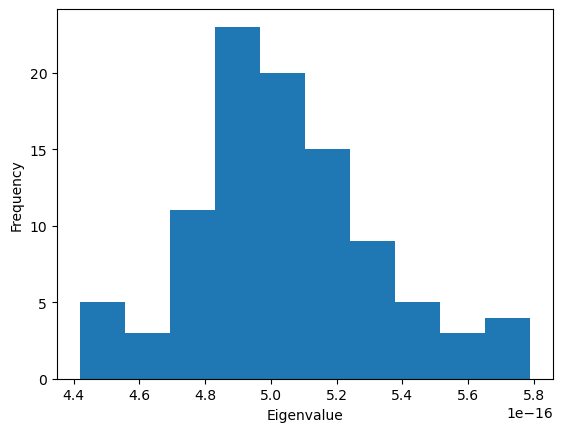

In [10]:
plt.hist(nma_close.results['eigenvalues'])
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')

Text(0, 0.5, 'Eigenvalue')

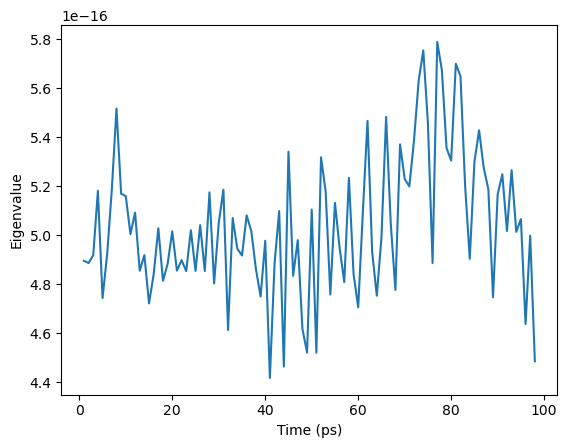

In [11]:
ax = plt.plot(nma_close.results['times'], nma_close.results['eigenvalues'])
plt.xlabel('Time (ps)')
plt.ylabel('Eigenvalue')

## Average radial distribution functions

In [12]:
from MDAnalysis.tests.datafiles import TPR, XTC
from MDAnalysis.analysis import rdf

# loading files
u = mda.Universe(TPR, XTC)

### Calculating the average radial distribution function for two groups of atoms

The average number of particles can be used to compute coordination numbers, such as the number of neighbours in the first solvation shell.

Below, I calculate the average RDF between each atom of residue 60 to each atom of water to look at the distribution of water over the trajectory. The RDF is limited to a spherical shell around each atom in residue 60 by range. Note that the range is defined around each atom, rather than the center-of-mass of the entire group.

In [13]:
res60 = u.select_atoms('resid 60')
water = u.select_atoms('resname SOL')

irdf = rdf.InterRDF(res60, water,
                    nbins=75,  # default
                    range=(0.0, 15.0),  # distance in angstroms
                   )
irdf.run()

In [14]:
# The distance bins are available at irdf.bins and 
# the radial distribution function is at irdf.rdf

irdf.results.bins


array([ 0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  4.3,
        4.5,  4.7,  4.9,  5.1,  5.3,  5.5,  5.7,  5.9,  6.1,  6.3,  6.5,
        6.7,  6.9,  7.1,  7.3,  7.5,  7.7,  7.9,  8.1,  8.3,  8.5,  8.7,
        8.9,  9.1,  9.3,  9.5,  9.7,  9.9, 10.1, 10.3, 10.5, 10.7, 10.9,
       11.1, 11.3, 11.5, 11.7, 11.9, 12.1, 12.3, 12.5, 12.7, 12.9, 13.1,
       13.3, 13.5, 13.7, 13.9, 14.1, 14.3, 14.5, 14.7, 14.9])

Text(0, 0.5, 'Radial distribution')

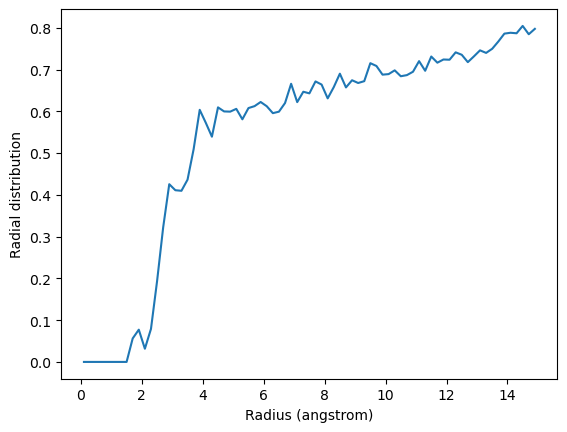

In [15]:
plt.plot(irdf.results.bins, irdf.results.rdf)
plt.xlabel('Radius (angstrom)')
plt.ylabel('Radial distribution')

In [16]:
irdf.results.count

array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 7.000e+00, 1.200e+01, 6.000e+00, 1.800e+01,
       5.200e+01, 1.010e+02, 1.540e+02, 1.700e+02, 1.920e+02, 2.300e+02,
       3.000e+02, 3.950e+02, 4.140e+02, 4.290e+02, 5.310e+02, 5.700e+02,
       6.190e+02, 6.780e+02, 7.020e+02, 7.910e+02, 8.560e+02, 9.320e+02,
       9.800e+02, 1.017e+03, 1.089e+03, 1.197e+03, 1.364e+03, 1.349e+03,
       1.483e+03, 1.556e+03, 1.713e+03, 1.783e+03, 1.781e+03, 1.950e+03,
       2.145e+03, 2.140e+03, 2.298e+03, 2.379e+03, 2.501e+03, 2.777e+03,
       2.868e+03, 2.900e+03, 3.024e+03, 3.186e+03, 3.244e+03, 3.382e+03,
       3.551e+03, 3.817e+03, 3.829e+03, 4.160e+03, 4.219e+03, 4.411e+03,
       4.557e+03, 4.824e+03, 4.943e+03, 4.980e+03, 5.237e+03, 5.507e+03,
       5.630e+03, 5.878e+03, 6.193e+03, 6.533e+03, 6.740e+03, 6.922e+03,
       7.276e+03, 7.293e+03, 7.616e+03])

### Calculating the average radial distribution function for a group of atoms to itself
You may want to calculate the average RDF for a group of atoms where atoms overlap; for instance, looking at residue 60 around itself. In this case you should avoid including contributions from atoms interacting with themselves. The `exclusion_block` keyword allows you to mask pairs within the same chunk of atoms. Here you can pass `exclusion_block=(1, 1)` to create chunks of size 1 and avoid computing the RDF to itself.

In [17]:
irdf2 = rdf.InterRDF(res60, res60,
                     exclusion_block=(1, 1))
irdf2.run()

Text(0, 0.5, 'Radial distribution')

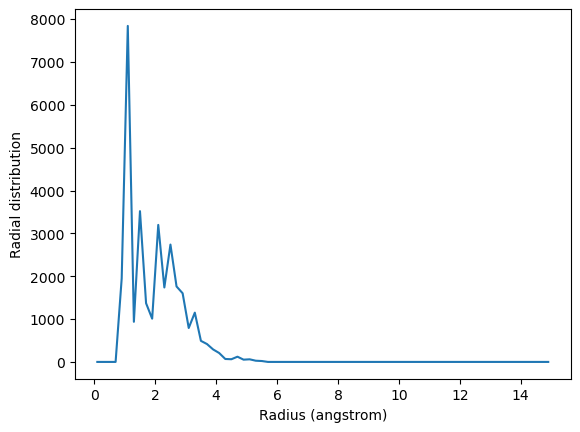

In [18]:
plt.plot(irdf2.results.bins, irdf2.results.rdf)
plt.xlabel('Radius (angstrom)')
plt.ylabel('Radial distribution')

In [19]:
thr = u.select_atoms('resname THR')
print('There are {} THR residues'.format(len(thr.residues)))
print('THR has {} atoms'.format(len(thr.residues[0].atoms)))

There are 11 THR residues
THR has 14 atoms


The code below calculates the RDF only using contributions from pairs of atoms where the two atoms are ***not*** in the same threonine residue.

In [20]:
irdf3 = rdf.InterRDF(thr, thr,
                     exclusion_block=(14, 14))
irdf3.run()

Text(0, 0.5, 'Radial distribution')

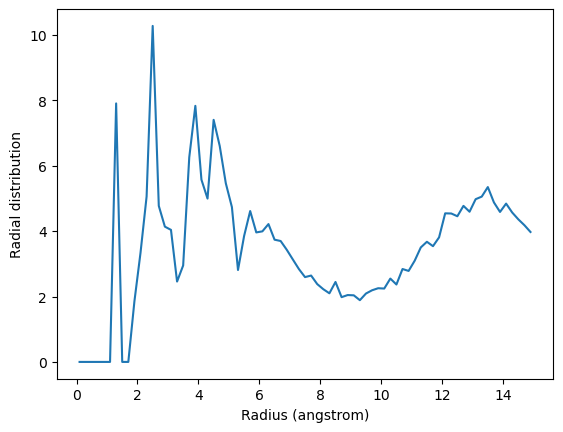

In [21]:
plt.plot(irdf3.results.bins, irdf3.results.rdf)
plt.xlabel('Radius (angstrom)')
plt.ylabel('Radial distribution')

# If you are splitting a residue over your two selections, 
# you can discount pairs from the same residue 
# by choosing appropriately sized exclusion blocks.

In [22]:
first = thr.residues[0]
print('THR has these atoms: ', ', '.join(first.atoms.names))
thr_c1 = first.atoms.select_atoms('name C*')
print('THR has {} carbons'.format(len(thr_c1)))
thr_other1 = first.atoms.select_atoms('not name C*')
print('THR has {} non carbons'.format(len(thr_other1)))

# The exclusion_block here ensures that the RDF is only computed 
# from threonine carbons to atoms in different threonine residues.

THR has these atoms:  N, H, CA, HA, CB, HB, OG1, HG1, CG2, HG21, HG22, HG23, C, O
THR has 4 carbons
THR has 10 non carbons


In [23]:
thr_c = thr.select_atoms('name C*')
thr_other = thr.select_atoms('not name C*')

irdf4 = rdf.InterRDF(thr_c, thr_other,
                     exclusion_block=(4, 10))
irdf4.run()

Text(0, 0.5, 'Radial distribution')

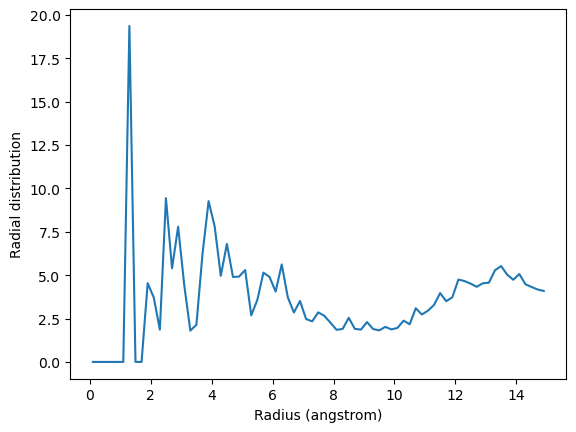

In [24]:
plt.plot(irdf4.results.bins, irdf4.results.rdf)
plt.xlabel('Radius (angstrom)')
plt.ylabel('Radial distribution')

## Calculating the RDF atom-to-atom
We calculate the site-specific radial distribution functions of solvent around certain atoms.

In [25]:
# loading files
u = mda.Universe(TPR, XTC)

### Calculating the site-specific radial distribution function
A radial distribution function gab(r) describes the time-averaged density of particles in b from the reference group a at distance r. It is normalised so that **it becomes 1 for large separations** in a homogenous system. The `InterRDF_s` class allows you to compute RDFs on an atom-to-atom basis, rather than simply giving the averaged RDF as in InterRDF.

Below, I calculate the RDF between selected alpha-carbons and the water atoms within 15 angstroms of CA60, in the first frame of the trajectory. The water group does not update over the trajectory as the water moves towards and away from the alpha-carbon.

The RDF is limited to a spherical shell around each atom by `range`. Note that the range is defined around each atom, rather than the center-of-mass of the entire group.

If `density=True`, the final RDF is over the average density of the selected atoms in the trajectory box, making it comparable to the output of `rdf.InterRDF`. If `density=False`, the density is not taken into account. This can make it difficult to compare RDFs between AtomGroups that contain different numbers of atoms.

In [26]:
ca60 = u.select_atoms('resid 61 and name CA')
ca61 = u.select_atoms('resid 62 and name CA')
ca62 = u.select_atoms('resid 63 and name CA')
water = u.select_atoms('resname SOL and sphzone 15 group sel_a', sel_a=ca60)

ags = [[ca60+ca61, water], [ca62, water]]

ss_rdf = rdf.InterRDF_s(u, ags,
                    nbins=75,  # default
                    range=(0.0, 15.0),  # distance
                    norm='density',
                   )
ss_rdf.run()

In [27]:
ss_rdf.results.bins

array([ 0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  4.3,
        4.5,  4.7,  4.9,  5.1,  5.3,  5.5,  5.7,  5.9,  6.1,  6.3,  6.5,
        6.7,  6.9,  7.1,  7.3,  7.5,  7.7,  7.9,  8.1,  8.3,  8.5,  8.7,
        8.9,  9.1,  9.3,  9.5,  9.7,  9.9, 10.1, 10.3, 10.5, 10.7, 10.9,
       11.1, 11.3, 11.5, 11.7, 11.9, 12.1, 12.3, 12.5, 12.7, 12.9, 13.1,
       13.3, 13.5, 13.7, 13.9, 14.1, 14.3, 14.5, 14.7, 14.9])

`s_rdf.rdf` contains the atom-pairwise RDF for each of your pairs of `AtomGroups`. It is a list with the same length as your list of pairs `ags`. A result array has the shape `(len(ag1), len(ag2), nbins)` for the AtomGroup pair `(ag1, ag2)`.

In [28]:
print('There are {} water atoms'.format(len(water)))
print('The first result array has shape: {}'.format(ss_rdf.results.rdf[0].shape))
print('The second result array has shape: {}'.format(ss_rdf.results.rdf[1].shape))

There are 1041 water atoms
The first result array has shape: (2, 1041, 75)
The second result array has shape: (1, 1041, 75)


Index the results array to get the RDF for a particular pair of atoms. `ss_rdf.rdf[i][j][k]` will return the RDF between atoms j
 and k in the i-th pair of atom groups. For example, below we get the RDF between the alpha-carbon in residue 61 (i.e. the second atom of the first atom group) and the 571st atom of water.

In [29]:
ca61_h2o_571 = ss_rdf.results.rdf[0][1][570]
ca61_h2o_571

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0023665 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00114292,
       0.00106921, 0.        , 0.00094167, 0.        , 0.        ,
       0.        , 0.0007466 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00055068, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0003116 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00025464, 0.00024669, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Text(0.5, 1.0, 'RDF between CA61 and MW6365')

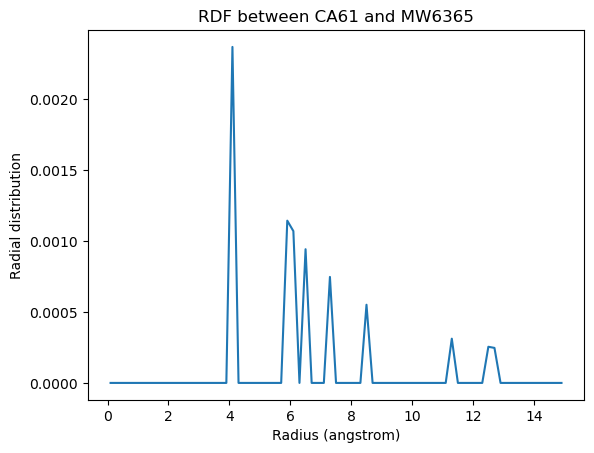

In [30]:
plt.plot(ss_rdf.results.bins, ca61_h2o_571)
w570 = water[570]
plt.xlabel('Radius (angstrom)')
plt.ylabel('Radial distribution')
plt.title('RDF between CA61 and {}{}'.format(w570.name, w570.resid))

If you are having trouble finding pairs of atoms where the results are not simply 0, you can use Numpy functions to find the indices of the nonzero values. Below we count the nonzero entries in the first `rdf` array.

In [31]:
j, k, nbin = np.nonzero(ss_rdf.results.rdf[0])
print(len(j), len(k), len(nbin))

4374 4374 4374


Each triplet of `[j, k, nbin]` indices is a nonzero value, corresponding to the `nbin`th bin between atoms j and k. For example:

In [32]:
print(f"{ss_rdf.results.rdf[0][j[0], k[0], nbin[0]]: .5f}")

 0.00028


Right now, we don’t care which particular bin has a nonzero value. Let’s find which water atom is the most present around the alpha-carbon of residue 60, i.e. the first atom.

In [33]:
# where j == 0, representing the first atom
water_for_ca60 = k[j==0]
# count how many of each atom index are in array
k_values, k_counts = np.unique(water_for_ca60,
                               return_counts=True)
# get the first k value with the most counts
k_max = k_values[np.argmax(k_counts)]
print('The water atom with the highest distribution '
      'around CA60 has index {}'.format(k_max))

The water atom with the highest distribution around CA60 has index 568


You can also calculate a cumulative distribution function for each of your results with `ss_rdf.get_cdf()`. This is the actual count of atoms within the given range, averaged over the trajectory; the volume of each radial shell is not taken into account. The result then gets saved into `ss_rdf.cdf`. The CDF has the same shape as the corresponding RDF array.

In [34]:
cdf = ss_rdf.get_cdf()
print(cdf[0].shape)

(2, 1041, 75)


Text(0.5, 1.0, 'RDF between CA60 and HW16365')

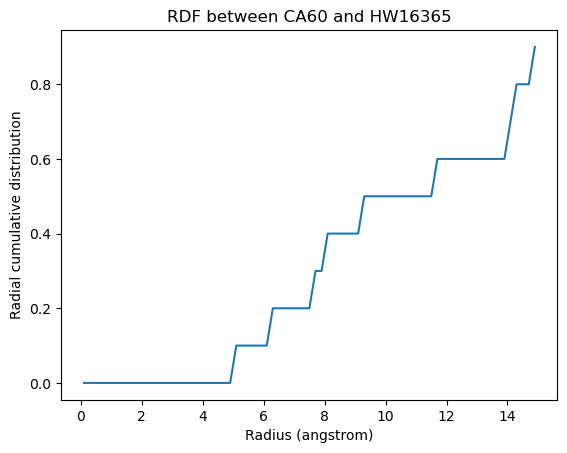

In [35]:
plt.plot(ss_rdf.results.bins, ss_rdf.results.cdf[0][0][568])
w568 = water[568]
plt.xlabel('Radius (angstrom)')
plt.ylabel('Radial cumulative distribution')
plt.title('RDF between CA60 and {}{}'.format(w568.name, w568.resid))

### The site-specific RDF without densities
When the `density` of the selected atom groups over the box volume is not accounted for, your distribution values will be proportionally lower.

In [36]:
ss_rdf_nodensity = rdf.InterRDF_s(u, ags,
                    nbins=75,  # default
                    range=(0.0, 15.0),  # distance
                    density=False,
                   )
ss_rdf_nodensity.run()
ss_rdf_nodensity.get_cdf()

[array([[[0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         ...,
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1]],
 
        [[0. , 0. , 0. , ..., 0. , 0.1, 0.1],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         ...,
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1]]]),
 array([[[0. , 0. , 0. , ..., 0. , 0.1, 0.1],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0.1, 0.1, 0.1],
         ...,
         [0. , 0. , 0. , ..., 0. , 0. , 0.1],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ]]])]

Text(0.5, 1.0, 'RDF between CA61 and MW6365')

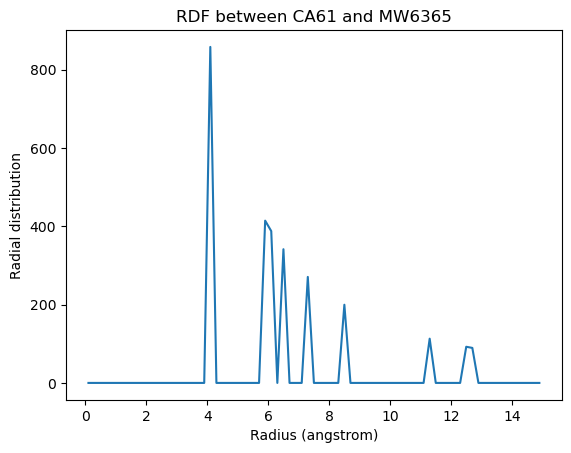

In [37]:
plt.plot(ss_rdf_nodensity.results.bins,
         ss_rdf_nodensity.results.rdf[0][1][570])
plt.xlabel('Radius (angstrom)')
plt.ylabel('Radial distribution')
plt.title('RDF between CA61 and {}{}'.format(w570.name, w570.resid))

## Protein dihedral angle analysis
We look at backbone dihedral angles and generate Ramachandran and Janin plots.

The methods and examples shown here are only applicable to Universes where protein residue names have standard names, i.e. the backbone is comprised of –N–CA–C–N–CA– atoms.

In [38]:
from MDAnalysis.analysis import dihedrals

# loading files
u = mda.Universe(GRO, XTC)
protein = u.select_atoms('protein')
print('There are {} residues in the protein'.format(len(protein.residues)))

There are 214 residues in the protein


### Calculating dihedral angles
MDAnalysis allows you to directly select the atoms involved in the ϕ, ψ, ω, and χ1 angles, provided that your protein atoms have standard names. If MDAnalysis cannot find atoms matching the names that it expects, it will return `None`. You can see below that `phi_selection` returns an ordered `AtomGroup` of the atoms in the ϕ angle of a residue if they can be found, and `None` if not.

* ϕ angle (`Residue.phi_selection`): C(i)---CA(i)

* ψ angle (`Residue.psi_selection`): C(i)---N(i+1)

* ω angle (`Residue.omega_selection`): C(i-1)---N(i)

* χ1 angle (`Residue.chi1_selection`): CA(i)---CB(i)

In [39]:
# selecting dihedral atom groups
for res in u.residues[210:220]:
    phi = res.phi_selection()
    if phi is None:
        names = None
    else:
        names = phi.names
    print('{}: {} '.format(res.resname, names))
LYS: ['C' 'N' 'CA' 'C']

LYS: ['C' 'N' 'CA' 'C'] 
ILE: ['C' 'N' 'CA' 'C'] 
LEU: ['C' 'N' 'CA' 'C'] 
GLY: ['C' 'N' 'CA' 'C'] 
SOL: None 
SOL: None 
SOL: None 
SOL: None 
SOL: None 
SOL: None 


In [40]:
# Calculate the dihedral angles for the protein
omegas = [res.omega_selection() for res in protein.residues[5:10]]
print(omegas[0].dihedral.value())

# The analysis.dihedrals.Dihedral class can be used to 
# rapidly calculate dihedrals for AtomGroups 
# over the entire trajectory.
dihs = dihedrals.Dihedral(omegas).run()

-169.78220560918737


In [41]:
dihs.results.angles.shape

(10, 5)

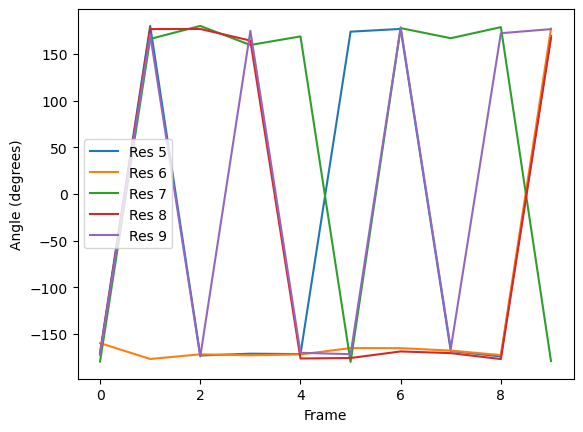

In [42]:
# plotting the dihedral angles
labels = ['Res {}'.format(n) for n in np.arange(5, 10)]
for ang, label in zip(dihs.results.angles.T, labels):
    plt.plot(ang, label=label)
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.legend()

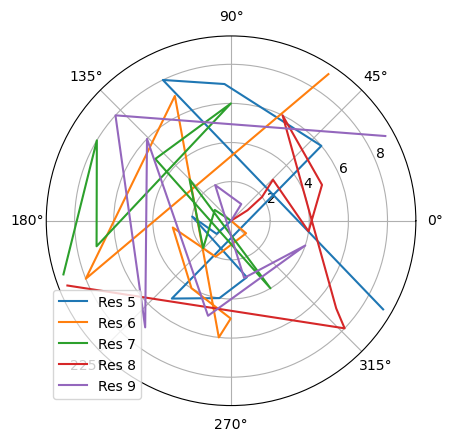

In [43]:
fig_polar = plt.figure()
ax_polar = fig_polar.add_subplot(111, projection='polar')
frames = np.arange(10)
for res, label in zip(dihs.results.angles.T, labels):
    c = ax_polar.plot(res, frames, label=label)
plt.legend()

### Ramachandran analysis
The `Ramachandran` class calculates the ϕ and ψ angles of the selected residues over the course of the trajectory, again saving it into `.angles`. If residues are given that do not contain a ϕ and ψ angle, they are omitted from the results. For example, the angles returned are from every residue in the protein except the first and last, for which a ϕ angle and a ψ  angle do not exist, respectively.

The returned `angles` are in the shape `(n_frames, n_residues, 2)` where the last dimension holds the ϕ and ψ angle.

In [44]:
rama = dihedrals.Ramachandran(protein).run()
print(rama.results.angles.shape)

(10, 212, 2)


You can plot this yourself, but `Ramachandran.plot()` is a convenience method that plots the data from each time step onto a standard Ramachandran plot. You can call it with no arguments; any keyword arguments that you give (except `ax` and `ref`) will be passed to `matplotlib.axes.Axes.scatter` to modify your plot.

<Axes: xlabel='$\\phi$', ylabel='$\\psi$'>

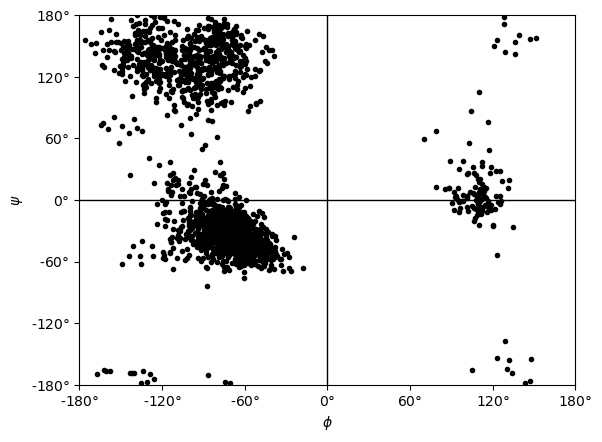

In [45]:
rama.plot(color='black', marker='.')

<Axes: xlabel='$\\phi$', ylabel='$\\psi$'>

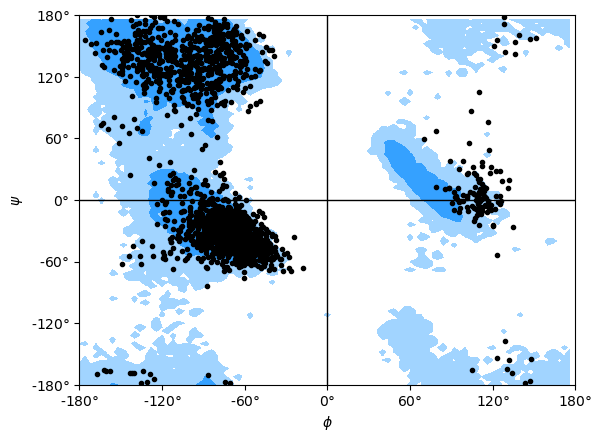

In [46]:
# If you set ref=True, your data will be plotted 
# with areas that show the allowed (dark blue) and 
# marginally allowed (lighter blue) regions.

rama.plot(color='black', marker='.', ref=True)

# These regions are computed from a reference set of 500 PDB files 
# from ([LDA+03]). The allowed region includes 90% data points, 
# while the marginally allowed region includes 99% data points.

### Janin analysis
The `Janin` class works similarly to the `Ramachandran` analysis, but looks at the χ1 and χ2 angles instead. It therefore ignores all residues without a long enough side-chain, such as alanine, cysteine, and so on.

Again, the returned `angles` are in the shape `(n_frames, n_residues, 2)` where the last dimension holds the χ1 and χ2 angle. We can see that only about half of the residues in AdK have side-chains long enough for this analysis.

In [47]:
janin = dihedrals.Janin(protein).run()
print(janin.results.angles.shape)

(10, 129, 2)


<Axes: xlabel='$\\chi_1$', ylabel='$\\chi_2$'>

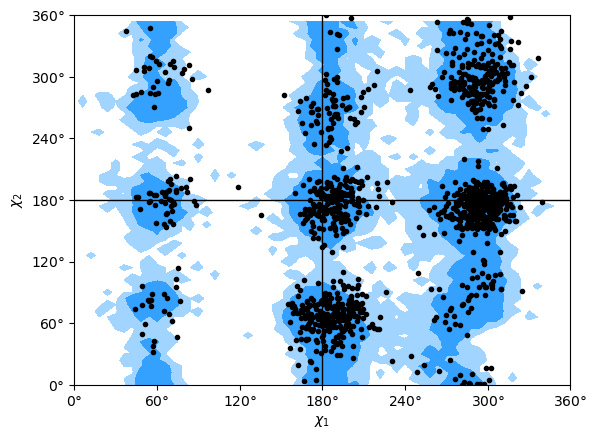

In [48]:
janin.plot(ref=True, marker='.', color='black')

## Helix analysis
We look at protein helices with HELANAL.

HELANAL can be used to characterize the geometry of helices with at least 9 residues. The geometry of an alpha helix is characterized by computing local helix axes and local helix origins for four contiguous C-alpha atoms, using the procedure of Sugeta and Miyazawa ([SM67]) and sliding this window over the length of the helix in steps of one C-alpha atom.

For each sliding window, it calculates:

* `local_rotation_vectors`: the vectors bisecting the angles of the middle 2 atoms

* `local_origins`: the projected origins of the helix

* `local_twists`: the twist of each window (θ)

* `residues_per_turn`: how many residues would fit in a turn, based on local_twist

* `local_axes`: the axis of each local helix

* `local_heights`: the rise of each helix

In [49]:
from MDAnalysis.analysis import helix_analysis as hel

# loading files
u = mda.Universe(PSF, DCD)

### Running the analysis
The default reference axis is the z-axis. You can also pass in a list of selection strings to run HELANAL on multiple helices at once.

In [50]:
h = hel.HELANAL(u, select='name CA and resnum 161-187',
                ref_axis=[0, 0, 1]).run()

The properties described above are stored as attributes in `h.results`. For example, the `all_bends` matrix contains the bends in a `(n_frames, n_residues-3, n_residues-3)` array.

In [51]:
h.results.all_bends.shape

(98, 24, 24)

Each property is also summarised with a mean value, the sample standard deviation, and the average deviation from the mean.

In [52]:
h.results.summary.keys()

dict_keys(['local_twists', 'local_bends', 'local_heights', 'local_nres_per_turn', 'local_origins', 'local_axes', 'local_helix_directions', 'local_screw_angles', 'global_axis', 'global_tilts', 'all_bends'])

In [53]:
for key, val in h.results.summary['global_tilts'].items():
    print(f"{key}: {val:.3f}")

mean: 86.121
sample_sd: 2.011
abs_dev: 1.715


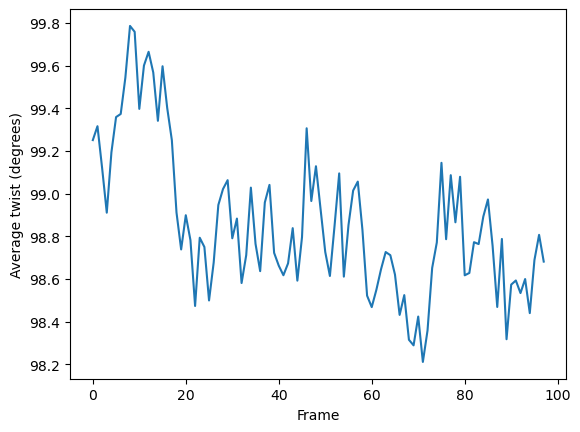

In [54]:
plt.plot(h.results.local_twists.mean(axis=1))
plt.xlabel('Frame')
plt.ylabel('Average twist (degrees)')
plt.show()

You can also create a Universe from the `local_origins` if you would like to save it as a file and visualise it in programs such as VMD.

In [55]:
origins = h.universe_from_origins()

In [56]:
import nglview as nv

view = nv.show_mdanalysis(h.atomgroups[0])
view.add_trajectory(origins)
view

NGLWidget(max_frame=97)

In [58]:
# from nglview.contrib.movie import MovieMaker

# movie = MovieMaker(view, 
#                    output='my.gif', 
#                    in_memory=True)
# movie.make()
